### LINEAR REGRESSION RE-IMPLEMENTATION

The key idea: learn how to find parameters w (weights) and b (bias) that minimize the prediction error.

In [49]:
import numpy as np
from enum import Enum
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


class LinearRegression:
    class Method(Enum):
        GRADIENT_DESCENT = 1

    def __init__(
        self,
        learning_rate=1e-5,
        epochs=2000,
        method=Method.GRADIENT_DESCENT,
        tol=1e-7,
    ):
        self.learning_rate = learning_rate
        self.m = None
        self.n = None
        self.epochs = epochs
        self.method = method
        self.tol = tol
        self.loss_history = []

    def fit(self, X, y):
        # m training samples, n features
        # convert the raw array into NDArray
        X = np.asarray(X)
        if X.ndim == 1:
            X = X.reshape(-1, 1)
        # (m, 1)
        y = np.asarray(y).reshape(-1, 1)

        # scale for X
        self.X_mean = np.mean(X, axis=0)
        self.X_std = np.std(X, axis=0)
        X = (X - self.X_mean) / (self.X_std + 1e-8)

        self.m, self.n = X.shape
        # initial sampling
        # the weights of the model
        self.w = np.zeros((self.n, 1))
        # the bias of the model
        self.b = 0.0

        # partial gradients
        # matrix
        def dJ_over_dw(error):
            return (1 / self.m) * (X.T @ error)

        def dJ_over_db(error):
            return (1 / self.m) * np.sum(error)

        # loss function (MSE)
        # matrix because of the number of data points
        def J(error):
            return np.sum(error ** 2) / (2 * self.m)

        previous_loss = float("inf")

        # the traning process using gradient descent
        # to find the parameters that make the J min
        for i in range(self.epochs):
            current_error = X @ self.w + self.b * np.ones((self.m, 1)) - y
            # forward pass
            j = J(current_error)
            # print("-Loss function: ", j)
            self.loss_history.append(j)

            # backward pass
            rate_of_change_J_w = dJ_over_dw(current_error)
            rate_of_change_J_b = dJ_over_db(current_error)

            # update parameters
            self.w = self.w - self.learning_rate * rate_of_change_J_w
            self.b = self.b - self.learning_rate * rate_of_change_J_b

            # convergence method
            if abs(j - previous_loss) < self.tol:
                # print(f"Convergence after {i} epochs")
                break

            previous_loss = j

    def predict(self, X):
        # (a, n) a new samples
        # (n, 1)
        # (a, 1)
        if X.ndim == 1:
            X = X.reshape(-1, 1)
        a, _ = X.shape

        # scale X
        X = (X - self.X_mean) / (self.X_std + 1e-8)

        return X @ self.w + self.b * np.ones((a, 1))

    def parameters(self):
        print("W: ", self.w)
        print("b: ", self.b)

    def view_loss(self):
        df = pd.DataFrame(
            data={"Epoch": range(len(self.loss_history)), "Loss": self.loss_history}
        )

        plt.figure(figsize=(7, 5))
        sns.lineplot(data=df, x="Epoch", y="Loss")

        plt.xlabel("Epoch")
        plt.ylabel("Loss (J)")
        plt.title("Loss vs Epoch")
        plt.grid(True)

        plt.show()

    def score(self, X, y):
        y = np.asarray(y).reshape(-1, 1)
        y_pred = self.predict(X)
        ss_total = np.sum((y - np.mean(y)) ** 2)
        ss_residual = np.sum((y - y_pred) ** 2)
        r2 = 1 - (ss_residual / ss_total)
        return r2

    def info(self):
        print("- Training samples: ", self.m)
        print("- Number of features: ", self.n)

    def get_params(self, deep=True):
        return {
            "learning_rate": self.learning_rate,
            "epochs": self.epochs,
            "method": self.method,
            "tol": self.tol,
        }

    def set_params(self, **params):
        for key, value in params.items():
            if hasattr(self, key):
                setattr(self, key, value)
        return self


### TRY THE IMPLEMENTED MODEL WITH A DATASET

#### DOWNLOAD THE DATASET

In [7]:
! pip install kaggle
! kaggle competitions download -c home-data-for-ml-course
! unzip ./home-data-for-ml-course.zip -d ./data/house
! rm ./home-data-for-ml-course.zip

  0%|                                                | 0.00/386k [00:00<?, ?B/s]
100%|████████████████████████████████████████| 386k/386k [00:00<00:00, 1.14GB/s]
Archive:  ./home-data-for-ml-course.zip
  inflating: ./data/house/data_description.txt  
  inflating: ./data/house/sample_submission.csv  
  inflating: ./data/house/sample_submission.csv.gz  
  inflating: ./data/house/test.csv   
  inflating: ./data/house/test.csv.gz  
  inflating: ./data/house/train.csv  
  inflating: ./data/house/train.csv.gz  


In [96]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

- Load the dataset

In [97]:
import pandas as pd

train = pd.read_csv(filepath_or_buffer="./data/house/train.csv")
test = pd.read_csv(filepath_or_buffer="./data/house/test.csv")

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [98]:
# Separating the train set
y = train['SalePrice'].values
X = train.drop(['SalePrice', 'Id'], axis=1)
X_test = test.drop(['Id'], axis=1)

- Separating the numerical and categorical features

In [99]:
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

- define the pipeline to preprocess and convert categorical features

In [100]:
# numeric preprocessing
imputer_num = SimpleImputer(strategy='median')
scaler = StandardScaler()
X_num = scaler.fit_transform(imputer_num.fit_transform(X[numeric_features]))
X_test_num = scaler.transform(imputer_num.transform(X_test[numeric_features]))

# categorical
imputer_cat = SimpleImputer(strategy='most_frequent')
encoder = OneHotEncoder(handle_unknown='ignore')

encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

X_cat_raw = imputer_cat.fit_transform(X[categorical_features])
X_cat = encoder.fit_transform(X_cat_raw)

X_test_cat_raw = imputer_cat.transform(X_test[categorical_features])
X_test_cat = encoder.transform(X_test_cat_raw)


# train
X_processed = np.hstack([X_num, X_cat])
# test
X_test_processed = np.hstack([X_test_num, X_test_cat])

- Use a simple val to tune hyperparameters

In [101]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X_processed, y, test_size=0.2, random_state=42
)

model = LinearRegression(epochs=6000, learning_rate=1e-2)
model.fit(X_train, y_train)

- evaluating on the validation set

In [102]:
y_pred = model.predict(X_valid)
rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
print(f"Validation RMSE: {rmse:.2f}")

Validation RMSE: 28341.25


- Train on the whole train set

In [103]:
best_model = LinearRegression(epochs=6000, learning_rate=1e-2)
best_model.fit(X_processed, y)

- generate the submissions

In [104]:
y_pred = model.predict(X_test_processed)
submission = pd.DataFrame({
    "Id": test["Id"],
    "SalePrice": y_pred.ravel()
})
submission.to_csv("./submissions/house.csv", index=False)

- IMAGE

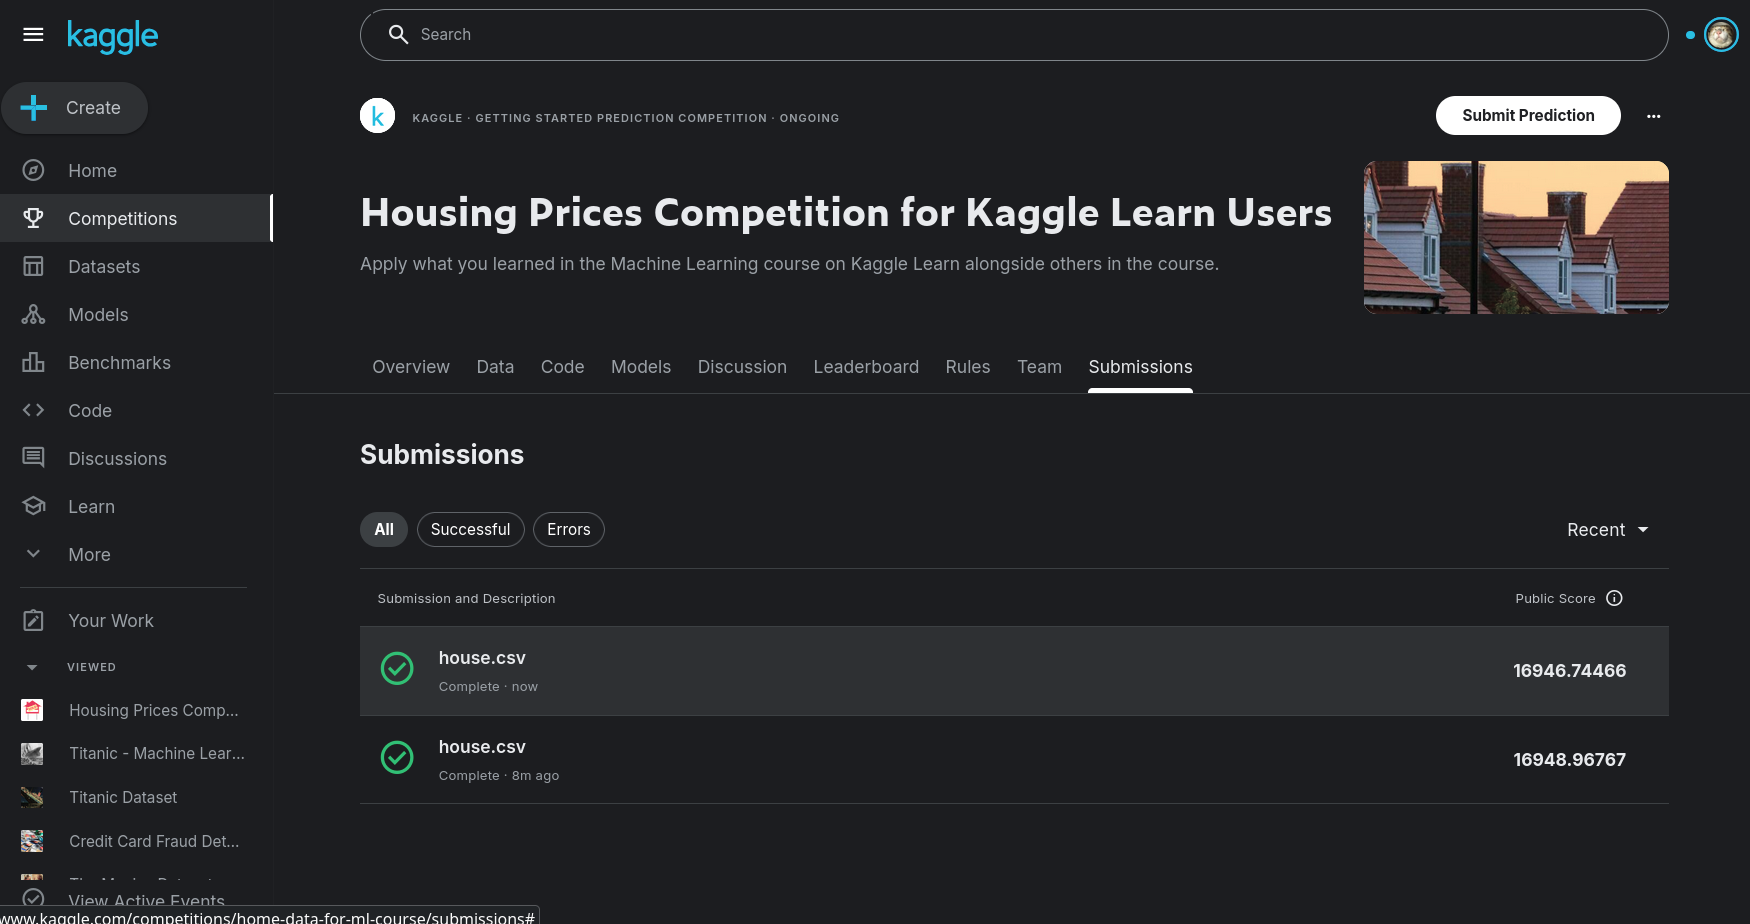

In [105]:
from IPython.display import Image, display

display(Image(filename='./submissions/house.png'))